### Importação de Bibliotecas

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd 
import numpy as np

### Leitura e Tratamento dos Dados

In [2]:
jogosCopa   = pd.read_csv('archive/WorldCupMatches.csv',encoding='utf-8')
ranking     = pd.read_csv('archive/fifa_ranking-2022-10-06.csv.zip')
jogos       = pd.read_csv('archive/results.csv')

In [3]:
jogos = jogos[(jogos["date"] < "2018-08-01")].dropna()

In [4]:
jogos[jogos['home_team']=='Sápmi']

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
29155,2006-11-23,Sápmi,Monaco,14.0,0.0,Viva World Cup,Hyères,France,True
29160,2006-11-24,Sápmi,Monaco,21.0,1.0,Viva World Cup,Hyères,France,True
30765,2008-07-07,Sápmi,Iraqi Kurdistan,2.0,2.0,Viva World Cup,Gällivare,Sweden,False
30769,2008-07-09,Sápmi,Arameans Suryoye,0.0,1.0,Viva World Cup,Gällivare,Sweden,False
30772,2008-07-11,Sápmi,Padania,0.0,2.0,Viva World Cup,Malmberget,Sweden,False
30775,2008-07-12,Sápmi,Provence,4.0,2.0,Viva World Cup,Gällivare,Sweden,False
30776,2008-07-13,Sápmi,Iraqi Kurdistan,3.0,1.0,Viva World Cup,Malmberget,Sweden,False
31692,2009-06-23,Sápmi,Provence,1.0,2.0,Viva World Cup,Varese,Italy,True
31696,2009-06-24,Sápmi,Gozo,7.0,2.0,Viva World Cup,Brescia,Italy,True
36362,2014-06-02,Sápmi,Abkhazia,1.0,2.0,CONIFA World Football Cup,Östersund,Sweden,False


In [5]:
jogos.groupby(['home_team'])['home_score'].sum().sort_values(ascending=False).head(50)
jogos.groupby(['away_team'])['away_score'].sum().sort_values(ascending=False).head(50)

away_team
England                1040.0
Germany                 869.0
Sweden                  863.0
Hungary                 825.0
Uruguay                 766.0
Brazil                  735.0
Netherlands             619.0
Poland                  612.0
Scotland                611.0
Argentina               608.0
Russia                  569.0
South Korea             569.0
Zambia                  554.0
Austria                 553.0
Norway                  550.0
Spain                   538.0
Denmark                 538.0
Paraguay                522.0
France                  516.0
Yugoslavia              501.0
Belgium                 501.0
Trinidad and Tobago     499.0
Mexico                  474.0
Romania                 473.0
Italy                   467.0
Switzerland             464.0
Bulgaria                419.0
Ghana                   412.0
Japan                   407.0
Uganda                  397.0
Thailand                391.0
Finland                 387.0
Czechoslovakia          368.0


In [6]:
import pandas as pd
import re
df =  pd.read_csv('archive/results.csv') #games between national teams
df["date"] = pd.to_datetime(df["date"])
df = df[(df["date"] >= "2014-7-13")].reset_index(drop=True) #games at the 2022 wc cycle
df_wc = df #pre-wc outcomes

rank = pd.read_csv('archive/fifa_ranking-2022-10-06.csv.zip') #rankings
rank["rank_date"] = pd.to_datetime(rank["rank_date"]) 
rank = rank[(rank["rank_date"] >= "2014-7-13")].reset_index(drop=True) #selecting games from the 2022 wc cycle
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States") #ajustando nomes de algumas seleções
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
rank_wc = rank #dataframe with rankings

#Making the merge
df_wc_ranked = df_wc.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked.dropna(inplace=True)

In [7]:
#Target -> 1 Vitoria da Casa,2 Vitoria  do visitante e 0  empate
df_wc_ranked['Target'] = np.where(df_wc_ranked['home_score']>df_wc_ranked['away_score'],1,
                         np.where(df_wc_ranked['home_score']<df_wc_ranked['away_score'],2,0))

In [8]:
df_wc_ranked['flag_amistoso'] = np.where(df_wc_ranked['tournament']=='Friendly',1,0)
df_wc_ranked['flag_is_campo_neutro'] = np.where(df_wc_ranked['neutral']==True,1,0)

In [9]:
golsTeam = jogos.groupby(['home_team'])['home_score'].sum().reset_index()
golsTeam.columns = ['pais','gols'] 
golsAway = jogos.groupby(['away_team'])['away_score'].sum().reset_index() 
golsAway.columns = ['pais','gols'] 
golsMarcados = pd.concat([golsTeam,golsAway])
golsMarcados = golsMarcados.groupby(['pais'])['gols'].sum().reset_index()

golsSofridosTeam = jogos.groupby(['home_team'])['away_score'].sum().reset_index()
golsSofridosTeam.columns = ['pais','gols'] 
golsSofridosAway = jogos.groupby(['away_team'])['home_score'].sum().reset_index() 
golsSofridosAway.columns = ['pais','gols'] 
golsSofridos = pd.concat([golsSofridosTeam,golsSofridosAway])
golsSofridos = golsSofridos.groupby(['pais'])['gols'].sum().reset_index()

golsMarcados['saldoDeGols'] = golsMarcados['gols']-golsSofridos['gols']
golsMarcados = golsMarcados.drop('gols',axis=1)
golsMarcados

,pais,saldoDeGols
0,Abkhazia,21.0
1,Afghanistan,-97.0
2,Albania,-215.0
3,Alderney,-54.0
4,Algeria,164.0
...,...,...
302,Yugoslavia,200.0
303,Zambia,399.0
304,Zanzibar,-247.0
305,Zimbabwe,94.0


In [10]:
jogosCopa = jogosCopa.drop_duplicates('MatchID')
jogosCopa = jogosCopa.dropna()
jogosCopa = jogosCopa.loc[:,['Year', 'Stage', 'Home Team Name',
  'Home Team Goals', 'Away Team Goals','Win conditions','Away Team Name',
  'Attendance', 'Half-time Home Goals','Half-time Away Goals',
  'RoundID', 'MatchID']]
jogosCopa = jogosCopa.replace('Germany FR','Germany')

In [11]:
jogosCopa['TargetCopa'] = np.where(jogosCopa['Home Team Goals']>jogosCopa['Away Team Goals'],jogosCopa['Home Team Name'],
                      np.where(jogosCopa['Home Team Goals']<jogosCopa['Away Team Goals'],jogosCopa['Away Team Name'],
                      np.where(jogosCopa.apply(lambda x: x['Home Team Name'] in x['Win conditions'],axis=1),jogosCopa['Home Team Name'],
                      np.where(jogosCopa.apply(lambda x: x['Away Team Name'] in x['Win conditions'],axis=1),jogosCopa['Away Team Name'],
                      'Empate'
                    ))))

In [12]:
#Quantidade de Copas Ganhas
#vencedores = jogosCopa[jogosCopa['Stage']=='Final'].groupby(['TargetCopa'])['TargetCopa'].count().sort_values(ascending=False).to_frame('QtdCopas').reset_index()

In [13]:
#df_wc_ranked = df_wc_ranked.merge(vencedores,how='left',right_on=['TargetCopa'],left_on=['home_team'])
#df_wc_ranked = df_wc_ranked.merge(vencedores,how='left',right_on=['TargetCopa'],left_on=['away_team'],suffixes=("_home", "_away")).drop(['TargetCopa_home','TargetCopa_away'],axis=1).fillna(0)

In [14]:
df_wc_ranked = df_wc_ranked.merge(golsMarcados,how='left',right_on=['pais'],left_on=['home_team'])
df_wc_ranked = df_wc_ranked.merge(golsMarcados,how='left',right_on=['pais'],left_on=['away_team'],suffixes=("_home", "_away")).drop(['pais_home','pais_away'],axis=1).fillna(0)

In [15]:
#X = df_wc_ranked.loc[:,'total_points_home':].drop('Target',axis=1)
X = df_wc_ranked[['total_points_home','previous_points_home', 'rank_home', 
        'total_points_away', 'previous_points_away', 'rank_away','Target',
       'saldoDeGols_home', 'saldoDeGols_away']].drop('Target',axis=1)
Y =  df_wc_ranked[['Target']]
X

,total_points_home,previous_points_home,rank_home,total_points_away,previous_points_away,rank_away,saldoDeGols_home,saldoDeGols_away
0,332.00,375.00,99.0,199.00,201.00,136.0,-125.0,-79.0
1,469.00,565.00,64.0,64.00,66.00,182.0,-101.0,-139.0
2,358.00,390.00,87.0,208.00,196.00,133.0,238.0,-180.0
3,354.00,386.00,91.0,234.00,247.00,121.0,-207.0,-47.0
4,375.00,393.00,82.0,276.00,271.00,109.0,-43.0,-40.0
...,...,...,...,...,...,...,...,...
6449,1361.81,1361.81,66.0,1379.61,1379.61,63.0,-215.0,-197.0
6450,1488.57,1488.57,36.0,1549.53,1549.53,25.0,-139.0,119.0
6451,1563.44,1563.44,20.0,1372.48,1372.48,65.0,698.0,-6.0
6452,1183.90,1183.90,106.0,1180.52,1180.52,108.0,-10.0,-470.0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=2)

In [17]:
rf = RandomForestClassifier(random_state=2,max_depth=5) 
model_rf = rf.fit(X_train,y_train)

C:\Users\h8men\AppData\Local\Temp\ipykernel_2488\4272274806.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf = rf.fit(X_train,y_train)


In [18]:
predict = model_rf.predict(X_test)
predict_train = model_rf.predict(X_train)
print(accuracy_score(predict,y_test)*100)
print(accuracy_score(predict_train,y_train)*100)

56.375838926174495
59.77418640690723


In [19]:
features = X.columns

In [20]:
features_importance = zip(model_rf.feature_importances_, features)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

rank_home: 19.043074%
rank_away: 17.952371%
saldoDeGols_away: 13.551115%
saldoDeGols_home: 12.540164%
total_points_home: 9.853515%
total_points_away: 9.511510%
previous_points_away: 9.218896%
previous_points_home: 8.329355%


In [21]:
#Quantidade de Vezes que foi para final
finalistas = pd.concat([jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Home Team Name'])['Home Team Name'].count(),
                        jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Away Team Name'])['Away Team Name'].count()])


In [22]:
#vencedores

In [23]:
ranking.groupby(['country_full'])['rank_change'].mean().sort_values(ascending=False).head(10)

country_full
Kosovo                      1.796610
South Sudan                 1.537736
Türkiye                     1.500000
São Tomé e Príncipe         1.000000
St. Vincent / Grenadines    0.579710
Serbia and Montenegro       0.395349
Bermuda                     0.344720
San Marino                  0.310204
Malta                       0.295031
São Tomé and Príncipe       0.260870
Name: rank_change, dtype: float64

In [24]:
jogosCopa.groupby(['Year'])['Year'].count()

Year
1930.0    18
1934.0    17
1938.0    18
1950.0    22
1954.0    26
1958.0    35
1962.0    32
1966.0    32
1970.0    32
1974.0    38
1978.0    38
1982.0    52
1986.0    52
1990.0    52
1994.0    52
1998.0    64
2002.0    64
2006.0    64
2010.0    64
2014.0    63
Name: Year, dtype: int64

### Variaveis
    var = { 'QTD_COPAS' :0, ✅
            'QtdFinais' :0, ✅
            'QtdSemi'   :0, ✅
            'Ranking'   :0, ✅
            'GOLS_COPAS':0,
            'Vit_5ULT_J':0,
            'Gol_5ULT_J':0
            'VitPorPub': JogVit/Pub
            
    }

<AxesSubplot: xlabel='TargetCopa'>

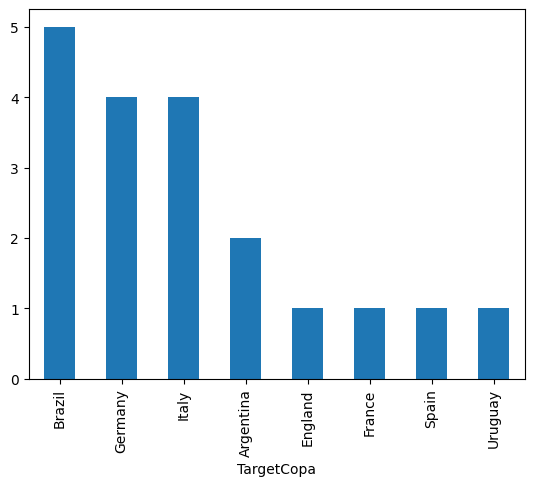

In [25]:
jogosCopa[jogosCopa['Stage']=='Final'].groupby(['TargetCopa'])['TargetCopa'].count().sort_values(ascending=False).plot.bar()

In [26]:
#Quantidade de Vezes que foi para final
(jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False)

Germany           8.0
Brazil            6.0
Italy             6.0
Argentina         5.0
Netherlands       3.0
Czechoslovakia    1.0
England           1.0
France            1.0
Hungary           1.0
Spain             1.0
Sweden            1.0
Uruguay           1.0
dtype: float64

In [27]:
(jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False).plot.bar

<bound method PlotAccessor.bar of <pandas.plotting._core.PlotAccessor object at 0x00000274320BAF50>>

In [28]:
jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Away Team Name'])['Away Team Name'].count()

Away Team Name
Argentina         2
Austria           2
Belgium           1
Brazil            2
Chile             1
Croatia           1
England           1
France            3
Germany           5
Italy             3
Korea Republic    1
Netherlands       2
Portugal          1
Soviet Union      1
Spain             1
Sweden            1
Turkey            1
USA               1
Uruguay           2
Yugoslavia        2
Name: Away Team Name, dtype: int64

In [29]:
#Quantidade de vezes que foi para Semifinais
(jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False)

Germany           12.0
Brazil             8.0
Italy              7.0
France             5.0
Uruguay            4.0
Argentina          4.0
Sweden             3.0
Netherlands        3.0
Portugal           2.0
England            2.0
Croatia            1.0
Belgium            1.0
USA                1.0
Turkey             1.0
Spain              1.0
Soviet Union       1.0
Poland             1.0
Czechoslovakia     1.0
Korea Republic     1.0
Austria            1.0
Hungary            1.0
Bulgaria           1.0
Chile              1.0
Yugoslavia         1.0
dtype: float64

In [30]:
jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Home Team Name'])['Away Team Name'].count()

Home Team Name
Argentina         2
Brazil            6
Bulgaria          1
Czechoslovakia    2
England           1
France            2
Germany           7
Hungary           2
Italy             4
Netherlands       1
Poland            1
Portugal          1
Sweden            2
Uruguay           2
Name: Away Team Name, dtype: int64

<AxesSubplot: >

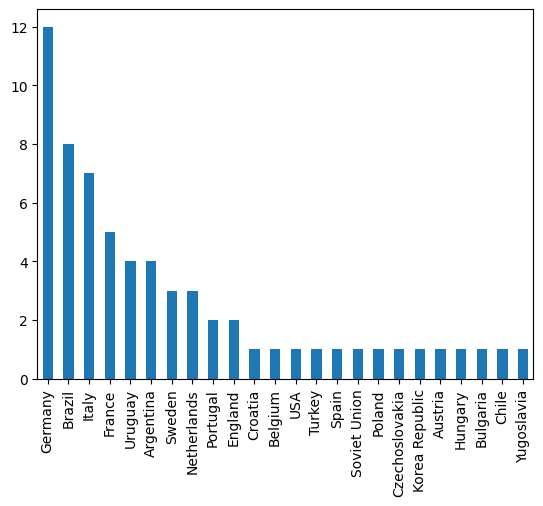

In [31]:
(jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False).plot.bar()

In [32]:
# (jogosCopa.groupby(['Home Team Name'])['Home Team Goals'].sum() +\
jogosCopa.groupby(['Away Team Name'])['Away Team Goals'].sum()
# ).sort_values(ascending=False)


Away Team Name
Algeria                        7.0
Angola                         1.0
Argentina                     22.0
Australia                      4.0
Austria                       12.0
                              ... 
rn">Bosnia and Herzegovina     1.0
rn">Republic of Ireland        8.0
rn">Serbia and Montenegro      2.0
rn">Trinidad and Tobago        0.0
rn">United Arab Emirates       2.0
Name: Away Team Goals, Length: 82, dtype: float64

In [33]:
ranking.groupby(['country_full'])['rank'].mean().sort_values().head(10)

country_full
Brazil          3.111801
Spain           5.580745
Argentina       5.745342
Germany         5.975155
France          8.273292
Italy           8.701863
Netherlands     9.363354
England         9.962733
Portugal       10.894410
Mexico         14.512422
Name: rank, dtype: float64

In [34]:
jogosCopa['Home Team Name'].unique()

array(['France', 'USA', 'Yugoslavia', 'Romania', 'Argentina', 'Chile',
       'Uruguay', 'Brazil', 'Paraguay', 'Austria', 'Hungary',
       'Switzerland', 'Sweden', 'Germany', 'Spain', 'Italy',
       'Czechoslovakia', 'Cuba', 'England', 'Turkey', 'Soviet Union',
       'Northern Ireland', 'Mexico', 'Wales', 'Portugal', 'Korea DPR',
       'Peru', 'Belgium', 'Bulgaria', 'German DR', 'Zaire', 'Poland',
       'Australia', 'Scotland', 'Netherlands', 'Haiti', 'Tunisia',
       'Algeria', 'Honduras', 'Canada', 'Morocco', 'Korea Republic',
       'Iraq', 'Denmark', 'rn">United Arab Emirates', 'Costa Rica',
       'Cameroon', 'rn">Republic of Ireland', 'Colombia', 'Norway',
       'Nigeria', 'Saudi Arabia', 'Bolivia', 'Russia', 'Greece',
       'Jamaica', 'South Africa', 'Japan', 'Croatia', 'China PR',
       'Senegal', 'Slovenia', 'Ecuador', 'rn">Trinidad and Tobago',
       'rn">Serbia and Montenegro', 'Angola', 'Czech Republic', 'Togo',
       'Iran', "C�te d'Ivoire", 'Ghana', 'Ukraine', 

In [35]:
jogosCopa.groupby(['Year'])['Year'].count()

Year
1930.0    18
1934.0    17
1938.0    18
1950.0    22
1954.0    26
1958.0    35
1962.0    32
1966.0    32
1970.0    32
1974.0    38
1978.0    38
1982.0    52
1986.0    52
1990.0    52
1994.0    52
1998.0    64
2002.0    64
2006.0    64
2010.0    64
2014.0    63
Name: Year, dtype: int64